In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import os
import shutil
import random
import kagglehub 
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [291]:
DATA_PATH = Path('data')
MODELS_PATH = Path('models')
IMG_SIZE = 96
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 4 # можно поставить больше если видеопамяти много
NUM_WORKERS = os.cpu_count()

# Формируем данные

Скачаем датасет и переместим его в нашу папку

In [ ]:
temp_data = kagglehub.dataset_download("nabilsherif/oil-spill") # скачиваем датасет

source = Path(temp_data) / 'oil-spill'

shutil.move(source, DATA_PATH) # перемещаем в папку

print(f'Files has been downloaded in {DATA_PATH}')

Посмотрим на датасет, какое изображение должно поступать на вход нашей модели и каким должен быть результат

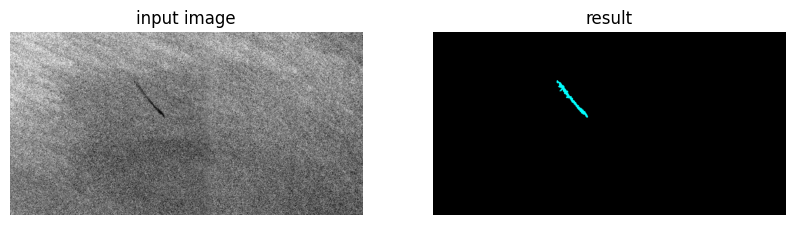

In [224]:
image1 = Image.open(Path(DATA_PATH) / 'train/images/img_0001.jpg')
image2 = Image.open(Path(DATA_PATH) / 'train/labels/img_0001.png')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(image1)
axes[0].axis("off")  
axes[0].set_title("input image")

axes[1].imshow(image2)
axes[1].axis("off")  
axes[1].set_title("result")

plt.show() 

Так как наш датасет содержит черно-белые изображения, создадим трансформацию, применив которую, мы получим чб фотографию с размером 96х96 в виде тензора

In [225]:
X_trans = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

y_trans = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

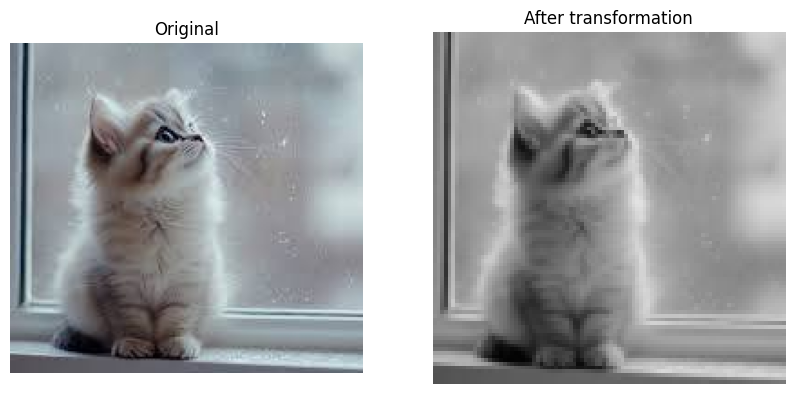

In [279]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(Image.open('cat.png'))
axes[0].axis(False)
axes[0].set_title('Original')

axes[1].imshow(X_trans(Image.open('cat.png')).permute(1, 2, 0))
axes[1].axis(False)
axes[1].set_title('After transformation')

plt.show()

Создадим датасеты и даталоадеры для обучения и тестирования.

In [ ]:
X_train_paths = sorted(list(os.walk(DATA_PATH / 'train/images'))[0][2])
y_train_paths = sorted(list(os.walk(DATA_PATH / 'train/labels'))[0][2])

X_test_paths = sorted(list(os.walk(DATA_PATH / 'test/images'))[0][2])
y_test_paths = sorted(list(os.walk(DATA_PATH / 'test/labels'))[0][2])


train_dataset = []
test_dataset = []

for ind in range(len(X_train_paths)):
    X = X_trans(Image.open(f'{DATA_PATH}/train/images/{X_train_paths[ind]}'))
    y = y_trans(Image.open(f'{DATA_PATH}/train/labels/{y_train_paths[ind]}'))
    train_dataset.append((X, y))

for ind in range(len(X_test_paths)):
    X = X_trans(Image.open(f'{DATA_PATH}/test/images/{X_test_paths[ind]}'))
    y = y_trans(Image.open(f'{DATA_PATH}/test/labels/{y_test_paths[ind]}'))
    test_dataset.append((X, y))


train_dataloader = DataLoader(train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset,
                             shuffle=False,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

Взглянем на случайные элементы даталоадера

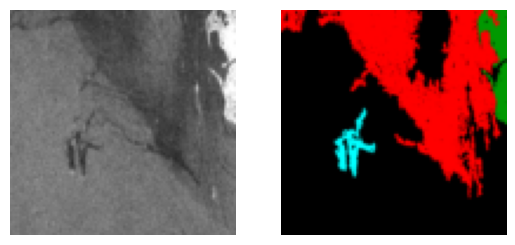

In [263]:
sample = random.choice(list(train_dataloader))

plt.subplot(1, 2, 1)
plt.imshow(sample[0][0].permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(sample[1][0].permute(1, 2, 0))
plt.axis(False)

plt.show()

# UNet

![unet.png](unet.png)


[U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597) - ссылка на статью

In [229]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.encode1 = nn.Sequential( # (3, 96, 96) -> (12, 96, 96) 
            nn.Conv2d(3, 12, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.ReLU()
        )

        self.encode2 = nn.Sequential( # (12, 96, 96) -> (24, 48, 48)
            nn.Conv2d(12, 24, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, 1, 1),
            nn.ReLU()
        )

        self.encode3 = nn.Sequential( # (24, 48, 48) -> (48, 24, 24)
            nn.Conv2d(24, 48, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(48, 48, 3, 1, 1),
            nn.ReLU()
        )

        self.encode4 = nn.Sequential( # (48, 24, 24) -> (96, 6, 6)
            nn.Conv2d(48, 96, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.ReLU()
        )

        self.bottleneck = nn.Sequential( # (96, 6, 6) -> (192, 3, 3) -> (96, 12, 12)
            nn.Conv2d(96, 192, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(192, 192, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(12),
            nn.Conv2d(192, 96, 3, 1, 1)
        )
        self.avgpool1 = nn.AdaptiveAvgPool2d((56, 56))
        self.decode1 = nn.Sequential( # (96, 12, 12) -> (48, 24, 24)
            nn.Conv2d(192, 96, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(24),
            nn.Conv2d(96, 48, 3, 1, 1)
        )
        self.avgpool2 = nn.AdaptiveAvgPool2d((104, 104))
        self.decode2 = nn.Sequential( # (48, 24, 24) -> (24, 48, 48)
            nn.Conv2d(96, 48, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(48, 48, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(48),
            nn.Conv2d(48, 24, 3, 1, 1)
        )
        self.avgpool3 = nn.AdaptiveAvgPool2d((200, 200))
        self.decode3 = nn.Sequential( # (24, 48, 48) -> (12, 96, 96)
            nn.Conv2d(48, 24, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, 1, 1),
            nn.ReLU(),
            nn.Upsample(96),
            nn.Conv2d(24, 12, 3, 1, 1)
        )
        self.avgpool4 = nn.AdaptiveAvgPool2d((392, 392))
        self.decode4 = nn.Sequential( # (12, 96, 96) -> (3, 96, 96)
            nn.Conv2d(24, 12, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(12, 12, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(12, 3, 3, 1, 1)

        )

    def forward(self, x):
        e1 = self.encode1(x)
        # print(e1.shape)
        e2 = self.encode2(self.pool(e1))
        # print(e2.shape)
        e3 = self.encode3(self.pool(e2))
        # print(e3.shape)
        e4 = self.encode4(self.pool(e3))
        # print(self.pool(e4).shape)

        #bottleneck

        bottle = self.bottleneck(e4)
        # print(bottle.shape)

        #decoding
        
        d1 = self.decode1(torch.cat((bottle, e4), 1))
        # print(d1.shape)
        d2 = self.decode2(torch.cat((d1, e3), 1))
        # print(d2.shape)
        d3 = self.decode3(torch.cat((d2, e2), 1))
        # print(d3.shape)
        d4 = self.decode4(torch.cat((d3, e1), 1))
        # print(d4.shape)
        return d4
    
unet_model = UNet().to(DEVICE)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=unet_model.parameters(), lr=0.001)

Протестируем модель

In [230]:
test_pred = unet_model(train_dataset[1][0].unsqueeze(0).to(DEVICE))
test_pred.shape

torch.Size([1, 3, 96, 96])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0775765..0.06314315].


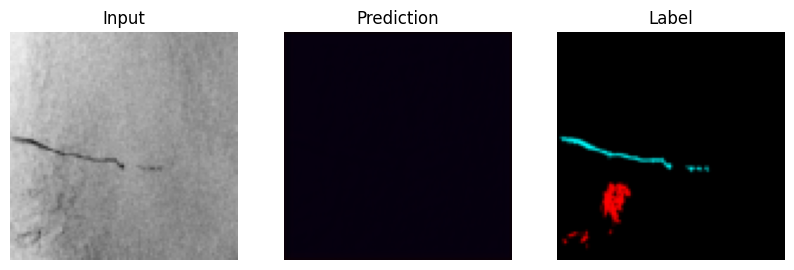

In [231]:
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

axes[0].imshow(train_dataset[1][0].permute(1, 2, 0))
axes[0].axis(False)
axes[0].set_title('Input')

axes[1].imshow(test_pred[0].permute(1, 2, 0).cpu().detach().numpy())
axes[1].axis(False)
axes[1].set_title('Prediction')

axes[2].imshow(train_dataset[1][1].permute(1, 2, 0))
axes[2].axis(False)
axes[2].set_title('Label')

plt.show()

Будем использовать следующую метрику:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [232]:
def IoU(pred, target, threshold=0.5):
    
    pred = (pred > threshold).float()
    
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    
    iou_value = intersection / union if union != 0 else torch.tensor(0.0)
    
    return iou_value.item()

In [233]:
IoU(test_pred, train_dataset[0][1].unsqueeze(0).to(DEVICE))

0.0

In [234]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    metric_fn,
    device,
    epochs,
    use_amp,
    scaler,
    scheduler):

    results = {'train_loss': [], 'train_met': [], 'test_loss': [], 'test_met': []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_met = 0, 0
        test_loss, test_met = 0, 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            model.train()
            with torch.autocast(device_type=device, enabled=use_amp):
                y_pred = model(X) 
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            train_loss += loss
            train_met += met
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            model.eval()
            with torch.inference_mode():
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
            met = metric_fn(y_pred, y)
            test_loss += loss
            test_met += met
        scheduler.step()
        print(f'EPOCH: {epoch}')
        print(f'train: metric - {train_met / len(train_dataloader)}% loss - {train_loss / len(train_dataloader)}')
        print(f'test: metric - {test_met / len(test_dataloader)}% loss - {test_loss / len(test_dataloader)}')
        results["train_loss"].append(train_loss / len(train_dataloader))
        results["train_met"].append(train_met / len(train_dataloader))
        results["test_loss"].append(test_loss / len(test_dataloader)) 
        results["test_met"].append(test_met / len(test_dataloader)) 
        print()
    return results

Запустим обучение модели.

In [235]:
unet_res = train(model=unet_model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                metric_fn=IoU,
                scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 13, 0.1),
                use_amp=True,
                device=DEVICE,
                scaler=torch.amp.GradScaler(),
                epochs=30)

  3%|▎         | 1/30 [00:04<01:58,  4.07s/it]

EPOCH: 0
train: metric - 0.0% loss - 0.1777963936328888
test: metric - 0.0% loss - 0.1296805739402771



  7%|▋         | 2/30 [00:08<01:54,  4.07s/it]

EPOCH: 1
train: metric - 0.0% loss - 0.13297773897647858
test: metric - 0.0% loss - 0.1028679758310318



 10%|█         | 3/30 [00:12<01:50,  4.10s/it]

EPOCH: 2
train: metric - 0.0% loss - 0.11474151909351349
test: metric - 0.0% loss - 0.09232652932405472



 13%|█▎        | 4/30 [00:16<01:46,  4.09s/it]

EPOCH: 3
train: metric - 0.007106247877081081% loss - 0.10504787415266037
test: metric - 0.020512093456740592% loss - 0.08965782076120377



 17%|█▋        | 5/30 [00:20<01:42,  4.08s/it]

EPOCH: 4
train: metric - 0.02952439801914031% loss - 0.10712701827287674
test: metric - 0.0% loss - 0.11266735941171646



 20%|██        | 6/30 [00:24<01:37,  4.08s/it]

EPOCH: 5
train: metric - 0.01587483671654305% loss - 0.1018732413649559
test: metric - 0.001814716502329767% loss - 0.08241953700780869



 23%|██▎       | 7/30 [00:28<01:36,  4.18s/it]

EPOCH: 6
train: metric - 0.039809000918322124% loss - 0.09565786272287369
test: metric - 0.056863698651016294% loss - 0.11387594044208527



 27%|██▋       | 8/30 [00:33<01:32,  4.20s/it]

EPOCH: 7
train: metric - 0.059284275630952794% loss - 0.09777819365262985
test: metric - 0.05105521819703946% loss - 0.07391312718391418



 30%|███       | 9/30 [00:37<01:27,  4.18s/it]

EPOCH: 8
train: metric - 0.06625380075915728% loss - 0.0943167433142662
test: metric - 0.007925493833941541% loss - 0.07638894021511078



 33%|███▎      | 10/30 [00:41<01:23,  4.17s/it]

EPOCH: 9
train: metric - 0.0630209271757088% loss - 0.09421651065349579
test: metric - 0.07242451234820432% loss - 0.08031661808490753



 37%|███▋      | 11/30 [00:45<01:19,  4.19s/it]

EPOCH: 10
train: metric - 0.07574894620597751% loss - 0.09098352491855621
test: metric - 0.0745203487361193% loss - 0.07642821967601776



 40%|████      | 12/30 [00:49<01:15,  4.19s/it]

EPOCH: 11
train: metric - 0.07112977079358611% loss - 0.09026873856782913
test: metric - 0.0749434053598504% loss - 0.07646410912275314



 43%|████▎     | 13/30 [00:54<01:11,  4.20s/it]

EPOCH: 12
train: metric - 0.0947627087948803% loss - 0.08673770725727081
test: metric - 0.10699418729304203% loss - 0.07686970382928848



 47%|████▋     | 14/30 [00:58<01:07,  4.24s/it]

EPOCH: 13
train: metric - 0.11522179114341502% loss - 0.07965776324272156
test: metric - 0.11281246891511339% loss - 0.06835770606994629



 50%|█████     | 15/30 [01:02<01:04,  4.28s/it]

EPOCH: 14
train: metric - 0.12091627488697998% loss - 0.07820603996515274
test: metric - 0.1420845274660678% loss - 0.07130399346351624



 53%|█████▎    | 16/30 [01:07<01:00,  4.29s/it]

EPOCH: 15
train: metric - 0.13028629040888204% loss - 0.07718739658594131
test: metric - 0.11669931582582649% loss - 0.06738369911909103



 57%|█████▋    | 17/30 [01:11<00:57,  4.45s/it]

EPOCH: 16
train: metric - 0.13839491921515515% loss - 0.07726964354515076
test: metric - 0.09468277368744436% loss - 0.06656195968389511



 60%|██████    | 18/30 [01:16<00:55,  4.60s/it]

EPOCH: 17
train: metric - 0.14204760955563614% loss - 0.07629610598087311
test: metric - 0.10987056420916426% loss - 0.06549837440252304



 63%|██████▎   | 19/30 [01:21<00:52,  4.75s/it]

EPOCH: 18
train: metric - 0.14043654194839142% loss - 0.0755617693066597
test: metric - 0.146197239741241% loss - 0.0687888115644455



 67%|██████▋   | 20/30 [01:26<00:46,  4.67s/it]

EPOCH: 19
train: metric - 0.14933476475982527% loss - 0.0751383826136589
test: metric - 0.1389177939158149% loss - 0.06487073004245758



 70%|███████   | 21/30 [01:30<00:41,  4.64s/it]

EPOCH: 20
train: metric - 0.1480882104259658% loss - 0.07492976635694504
test: metric - 0.1507870054421281% loss - 0.06698992103338242



 73%|███████▎  | 22/30 [01:35<00:36,  4.59s/it]

EPOCH: 21
train: metric - 0.14848569347381693% loss - 0.07427555322647095
test: metric - 0.1480003099422902% loss - 0.06396155804395676



 77%|███████▋  | 23/30 [01:39<00:31,  4.50s/it]

EPOCH: 22
train: metric - 0.17155202381553794% loss - 0.07369787245988846
test: metric - 0.09276425952391167% loss - 0.06331547349691391



 80%|████████  | 24/30 [01:44<00:26,  4.43s/it]

EPOCH: 23
train: metric - 0.16007728864224555% loss - 0.07295124232769012
test: metric - 0.1276196310895362% loss - 0.06186271831393242



 83%|████████▎ | 25/30 [01:48<00:21,  4.38s/it]

EPOCH: 24
train: metric - 0.17327320529704549% loss - 0.0723070353269577
test: metric - 0.1496137466996775% loss - 0.061852455139160156



 87%|████████▋ | 26/30 [01:53<00:17,  4.49s/it]

EPOCH: 25
train: metric - 0.17749791713366544% loss - 0.07173497974872589
test: metric - 0.13747879047878087% loss - 0.06159472465515137



 90%|█████████ | 27/30 [01:58<00:14,  4.89s/it]

EPOCH: 26
train: metric - 0.17707452738882076% loss - 0.0703071653842926
test: metric - 0.1481736883454557% loss - 0.06032813340425491



 93%|█████████▎| 28/30 [02:03<00:09,  4.76s/it]

EPOCH: 27
train: metric - 0.17983461767031564% loss - 0.06973803788423538
test: metric - 0.17644150536839984% loss - 0.06122914329171181



 97%|█████████▋| 29/30 [02:07<00:04,  4.58s/it]

EPOCH: 28
train: metric - 0.1932180568124112% loss - 0.06997544318437576
test: metric - 0.18827328759445144% loss - 0.061136066913604736



100%|██████████| 30/30 [02:11<00:00,  4.39s/it]

EPOCH: 29
train: metric - 0.19983292358732166% loss - 0.06945452839136124
test: metric - 0.17778929249782646% loss - 0.06154628098011017



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.263693..1.8301282].


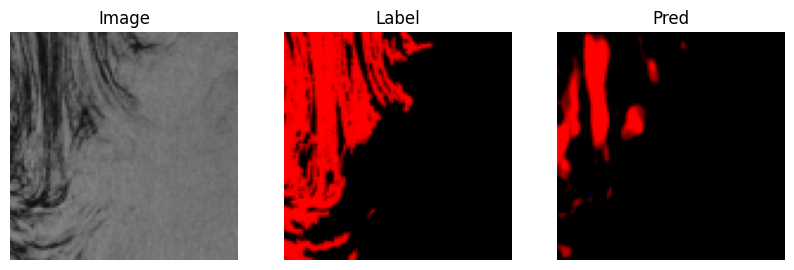

IoU - 0.27502307295799255


In [288]:
ind = random.choice(range(len(test_dataset)))
test_pred = unet_model(test_dataset[ind][0].unsqueeze(0).to(DEVICE))

fig, axes = plt.subplots(1, 3, figsize=(10, 8))

axes[0].imshow(test_dataset[ind][0].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
axes[0].set_title("Image")
axes[0].axis(False)

axes[1].imshow(test_dataset[ind][1].permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
axes[1].set_title("Label")
axes[1].axis(False)

axes[2].imshow(test_pred.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(), cmap="gray")
axes[2].set_title("Pred")
axes[2].axis(False)

plt.show()
print(f"IoU - {IoU(test_pred, test_dataset[ind][1].unsqueeze(0).to(DEVICE))}")

# Сохраняем веса

In [292]:
from pathlib import Path

if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)

torch.save(unet_model.state_dict(), f="models/model_0.pth")